In [1]:
from __future__ import print_function
import numpy as np
import pandas as pd
import cv2
import os
batch_size = 32
epochs = 12
import keras
from keras.models import Model,Sequential
from keras.layers import Lambda, Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, GaussianNoise, Input, Dropout, concatenate
from keras import optimizers
from keras.preprocessing.image import img_to_array
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
learning_rate = 0.0002
input_shape = (None,None,3)
# from keras.applications import ResNet50, VGG16,VGG19
import keras.backend as K
from keras.backend import tf as ktf


Using TensorFlow backend.


In [2]:
data_dir = "../input/"
(x_train, y_train_length, y_train_width, y_train_color, y_train_angle) = (np.load(data_dir +'x_train.npy'), np.load(data_dir+'y_train_length.npy'), np.load(data_dir+'y_train_width.npy'), np.load(data_dir+'y_train_color.npy'), np.load(data_dir+'y_train_angle.npy'))
(x_test, y_test_length, y_test_width, y_test_color, y_test_angle) = (np.load(data_dir+'x_test.npy'), np.load(data_dir+'y_test_length.npy'), np.load(data_dir+'y_test_width.npy'), np.load(data_dir+'y_test_color.npy'), np.load(data_dir+'y_test_angle.npy'))

In [3]:
def inception_block(x, filters):
#     last = x

    net1 = Conv2D(filters = filters, kernel_size=(1,1), padding='Same', activation = 'relu')(x)

    net2 = Conv2D(filters = filters, kernel_size=(1,1), padding='Same', activation = 'relu')(x)
    net2 = Conv2D(filters = filters, kernel_size=(3,3), padding='Same', activation = 'relu')(net2)

    net3 = Conv2D(filters = filters, kernel_size=(1,1), padding='Same', activation = 'relu')(x)
    net3 = Conv2D(filters = filters, kernel_size=(3,3), padding='Same', activation = 'relu')(net3)
    net3 = Conv2D(filters = filters, kernel_size=(3,3), padding='Same', activation = 'relu')(net3)

    output = concatenate([net1, net2, net3], axis=3)
    return output

In [4]:
input_tensor = Input(shape=(28, 28, 3))

x = Conv2D(filters = 32, kernel_size=(3,3), padding='Same', activation = 'relu')(input_tensor)
x = Conv2D(filters = 32, kernel_size=(3,3), padding='Same', activation = 'relu')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(5, 5), strides=(2,2))(x)

x = inception_block(x,32)
x = MaxPool2D(pool_size=(3, 3), strides=(1,1),padding='Same')(x)
x = Flatten()(x)

length = Dense(128, activation = 'sigmoid')(x)
length = Dropout(0.25)(length)
length = Dense(1, activation = 'sigmoid',name = 'length')(length)

width = Dense(1, activation = 'sigmoid',name = 'width')(x)

color = Dense(1, activation = 'sigmoid',name = 'color')(x)

angle = Dense(256, activation = 'softmax',name = 'angle')(x)
angle = Dropout(0.5)(x)
angle = Dense(12, activation = 'softmax',name = 'angle')(angle)

model = Model(input_tensor,[length, width, color, angle] )
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 28, 28, 32)   9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1

In [5]:
# epochs = 12

# dataset_len = x_train.shape[0]
# decay_rate = learning_rate / ((dataset_len / batch_size) * epochs)

# optimizer = optimizers.Adam(learning_rate, 0.5, decay=decay_rate)
loss = ['binary_crossentropy', 'binary_crossentropy', 'binary_crossentropy', 'sparse_categorical_crossentropy']
loss_weights = [0.1, 0.1, 0.1, 2.0]
model.compile(optimizer='adam',
              loss=loss,
              loss_weights = loss_weights,
              metrics=['accuracy'])
# len(labels[1])

In [7]:
history = model.fit(x_train, [y_train_length, y_train_width, y_train_color, y_train_angle], epochs=epochs, batch_size=batch_size, shuffle=True,verbose=1)
model.save_weights("line_2_final.h5")

Instructions for updating:
Use tf.cast instead.
Epoch 1/12
57600/57600 [==============================] - 25s 442us/step - loss: 0.6880 - length_loss: 0.0739 - width_loss: 0.0760 - color_loss: 0.0371 - angle_loss: 0.3347 - length_acc: 0.9760 - width_acc: 0.9766 - color_acc: 0.9936 - angle_acc: 0.8918
Epoch 2/12
57600/57600 [==============================] - 24s 411us/step - loss: 0.0774 - length_loss: 0.0119 - width_loss: 0.0189 - color_loss: 0.0109 - angle_loss: 0.0366 - length_acc: 0.9978 - width_acc: 0.9944 - color_acc: 0.9972 - angle_acc: 0.9899
Epoch 3/12
57600/57600 [==============================] - 24s 411us/step - loss: 0.0553 - length_loss: 0.0125 - width_loss: 0.0179 - color_loss: 0.0122 - angle_loss: 0.0255 - length_acc: 0.9968 - width_acc: 0.9951 - color_acc: 0.9965 - angle_acc: 0.9934
Epoch 4/12
57600/57600 [==============================] - 24s 419us/step - loss: 0.0465 - length_loss: 0.0079 - width_loss: 0.0183 - color_loss: 0.0125 - angle_loss: 0.0213 - length_acc: 0.9

In [8]:
model.evaluate(x_test, [y_test_length, y_test_width, y_test_color, y_test_angle])

38400/38400 [==============================] - 4s 107us/step


[0.008823710792826395,
 0.002945333501093123,
 0.04352974240705242,
 0.002240972957864287,
 0.0019760529467339437,
 0.9991145833333334,
 0.9900260416666666,
 0.9996354166666667,
 0.999375]

In [21]:
def plot_history(history):
	hist = pd.DataFrame(history.history)
	hist['epoch'] = history.epoch
	plt.figure()
	plt.xlabel('Epoch')
	plt.ylabel('Loss')
	plt.plot(hist['epoch'], hist['length_loss'],
	       label='Length Loss')
	plt.plot(hist['epoch'], hist['width_loss'],
	       label='Width Loss')
	plt.plot(hist['epoch'], hist['color_loss'],
	       label='Color Loss')
	plt.plot(hist['epoch'], hist['angle_loss'],
	       label='Angle Loss')
	plt.plot(hist['epoch'], hist['loss'],
	       label='Train Loss')
# 	plt.ylim([0,1])
	plt.legend()
	plt.savefig('loss_plot.png')

	plt.figure()
	plt.xlabel('Epoch')
	plt.ylabel('Accuracy')

	plt.plot(hist['epoch'], hist['length_acc'],
	       label='Length Acc')
	plt.plot(hist['epoch'], hist['width_acc'],
	       label='Width Acc')
	plt.plot(hist['epoch'], hist['color_acc'],
	       label='Color Acc')
	plt.plot(hist['epoch'], hist['angle_acc'],
	       label='Angle Acc')
# 	plt.ylim([0,1])
	plt.legend()
	plt.savefig('acc_plot.png')
#

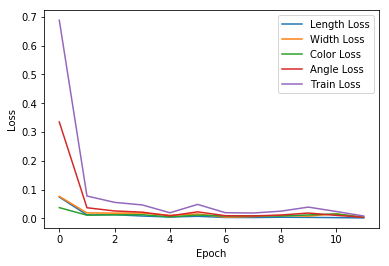

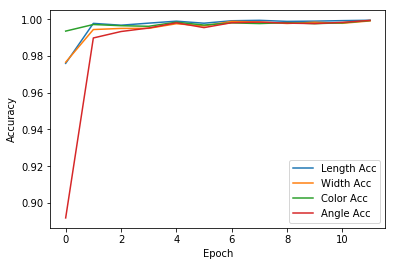

In [22]:
plot_history(history)

In [24]:
keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=True,
#     show_layer_names=True,
#     rankdir='TB'
)


In [53]:
pred = model.predict(x_test)

In [54]:
# pred[0][5]

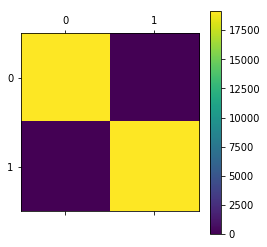

In [55]:
l = pred[0]
l[l>=0.5] = 1
l[l<0.5] = 0


cm_l = confusion_matrix(y_test_length,l)
cm_l
np.save("confusion_matrix_l.npy",cm_l)
plt.matshow(cm_l)
plt.colorbar()
plt.savefig("confusion_l.jpg")

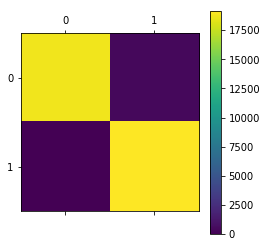

In [56]:
w=pred[1]
w[w>=0.5] = 1
w[w<0.5] = 0

cm_w = confusion_matrix(y_test_width,w)
np.save("confusion_matrix_w.npy",cm_w)
plt.matshow(cm_w)
plt.colorbar()
plt.savefig("confusion_w.jpg")

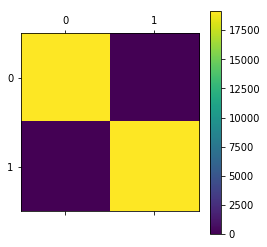

In [57]:
c = pred[2]
c[c>=0.5] = 1
c[c<0.5] = 0
cm_c = confusion_matrix(y_test_color,c)
np.save("confusion_matrix_c.npy",cm_c)
plt.matshow(cm_c)
plt.colorbar()
plt.savefig("confusion_c.jpg")

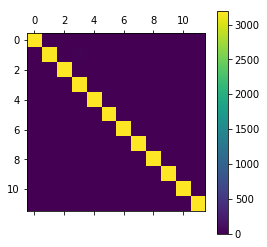

In [58]:
a = []
for i in pred[3]:
    x=np.argmax(i)
    a.append(x)
a = np.array(a)

cm_a = confusion_matrix(y_test_angle,a)
np.save("confusion_matrix_a.npy",cm_a)
plt.matshow(cm_a)
plt.colorbar()
plt.savefig("confusion_a.jpg")